# Examen: Modulo 1

In [171]:
from libreria_modulo_1 import analysis, preprocessing, visualization 
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, asin


## 0. Carga de datos

In [172]:
# Cargar todos los datasets de la carpeta datos
users = pd.read_csv('datos/users.csv')
usercuisine = pd.read_csv('datos/usercuisine.csv')
userpayment = pd.read_csv('datos/userpayment.csv')
ratings = pd.read_csv('datos/ratings.csv')
restaurants = pd.read_csv('datos/restaurants.csv')
parking = pd.read_csv('datos/parking.csv')
cuisine = pd.read_csv('datos/cuisine.csv')
payment_methods = pd.read_csv('datos/payment_methods.csv')
hours = pd.read_csv('datos/hours.csv')

# Reemplazar '?' con NaN en todos los dataframes
dataframes = {
    'users': users,
    'usercuisine': usercuisine,
    'userpayment': userpayment,
    'ratings': ratings,
    'restaurants': restaurants,
    'parking': parking,
    'cuisine': cuisine,
    'payment_methods': payment_methods,
    'hours': hours
}

for name, df in dataframes.items():
    dataframes[name] = df.replace('?', np.nan).infer_objects(copy=False)

# Actualizar las variables originales
users = dataframes['users']
usercuisine = dataframes['usercuisine']
userpayment = dataframes['userpayment']
ratings = dataframes['ratings']
restaurants = dataframes['restaurants']
parking = dataframes['parking']
cuisine = dataframes['cuisine']
payment_methods = dataframes['payment_methods']
hours = dataframes['hours']

print("✅ Datasets cargados exitosamente:")
for name, df in dataframes.items():
    print(f"  - {name}: {df.shape[0]} filas x {df.shape[1]} columnas")

✅ Datasets cargados exitosamente:
  - users: 138 filas x 19 columnas
  - usercuisine: 330 filas x 2 columnas
  - userpayment: 177 filas x 2 columnas
  - ratings: 1161 filas x 5 columnas
  - restaurants: 130 filas x 21 columnas
  - parking: 702 filas x 2 columnas
  - cuisine: 916 filas x 2 columnas
  - payment_methods: 1314 filas x 2 columnas
  - hours: 2339 filas x 3 columnas


C:\Users\leono\AppData\Local\Temp\ipykernel_25064\1481817673.py:26: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



## 1. Analisis de Datos

## 1.1Creacion de columnas Ingeniería de datos:

 Teniendo muy presente la unidad muestral, genere al menos 5 variables adicionales a las proporcionadas individualmente. 

In [173]:
def crear_variables_calificaciones(ratings, users, restaurants, 
                                  usercuisine, cuisine, 
                                  userpayment, payment_methods):
    """
    PASO 1: Crear las 5 variables adicionales
    """
    # 1. Dataset base
    df = ratings.copy()
    
    # 2. Unir datos
    df = df.merge(
        users[['userID', 'latitude', 'longitude', 'smoker', 
              'dress_preference', 'budget', 'ambience']],
        on='userID'
    )
    
    df = df.merge(
        restaurants[['placeID', 'latitude', 'longitude', 'smoking_area',
                    'dress_code', 'price', 'Rambience', 'alcohol']],
        on='placeID',
        suffixes=('_user', '_rest')
    )
    
    # 3. Función distancia
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        return R * 2 * asin(sqrt(a))
    
    # Variable 1: distancia_km
    df['distancia_km'] = df.apply(
        lambda row: haversine(row['latitude_user'], row['longitude_user'],
                             row['latitude_rest'], row['longitude_rest']),
        axis=1
    )
    
    # Diccionarios para búsqueda rápida
    user_cuisine_dict = usercuisine.groupby('userID')['Rcuisine'].apply(set).to_dict()
    rest_cuisine_dict = cuisine.groupby('placeID')['Rcuisine'].apply(set).to_dict()
    user_payment_dict = userpayment.groupby('userID')['Upayment'].apply(set).to_dict()
    rest_payment_dict = payment_methods.groupby('placeID')['Rpayment'].apply(set).to_dict()
    
    # Variable 2: match_cocina (0/1)
    def check_cocina_match(user_id, place_id):
        user_set = user_cuisine_dict.get(user_id, set())
        rest_set = rest_cuisine_dict.get(place_id, set())
        return 1 if len(user_set & rest_set) > 0 else 0
    
    df['match_cocina'] = df.apply(
        lambda row: check_cocina_match(row['userID'], row['placeID']), axis=1
    )
    
    # Variable 3: compat_fumador (0,1,2)
    def compat_fumador(smoker, smoking_area):
        if smoker == 'true':
            return 2 if smoking_area != 'none' else 0
        else:
            return 1
    
    df['compat_fumador'] = df.apply(
        lambda row: compat_fumador(row['smoker'], row['smoking_area']), axis=1
    )
    
    # Variable 4: payment_match_ratio (0-1)
    def payment_match_ratio(user_id, place_id):
        user_set = user_payment_dict.get(user_id, set())
        rest_set = rest_payment_dict.get(place_id, set())
        
        if len(user_set) == 0:
            return 0
        return len(user_set & rest_set) / len(user_set)
    
    df['payment_match_ratio'] = df.apply(
        lambda row: payment_match_ratio(row['userID'], row['placeID']), axis=1
    )
    
    # Variable 5: match_ambiente (0/1)
    df['match_ambiente'] = (df['ambience'] == df['Rambience']).astype(int)
    
    return df

# Aplicar función
df_enriquecido = crear_variables_calificaciones(
    ratings, users, restaurants, usercuisine, cuisine, 
    userpayment, payment_methods
)

print("✓ Variables creadas")
print(f"Dataset shape: {df_enriquecido.shape}")
print(f"Columnas: {list(df_enriquecido.columns)}")



✓ Variables creadas
Dataset shape: (1161, 23)
Columnas: ['userID', 'placeID', 'rating', 'food_rating', 'service_rating', 'latitude_user', 'longitude_user', 'smoker', 'dress_preference', 'budget', 'ambience', 'latitude_rest', 'longitude_rest', 'smoking_area', 'dress_code', 'price', 'Rambience', 'alcohol', 'distancia_km', 'match_cocina', 'compat_fumador', 'payment_match_ratio', 'match_ambiente']


In [174]:
df_enriquecido.head()

,userID,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,smoker,dress_preference,budget,...,smoking_area,dress_code,price,Rambience,alcohol,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente
0,U1077,135085,2,2,2,22.156469,-100.985540,false,elegant,medium,...,not permitted,informal,medium,familiar,No_Alcohol_Served,0.695581,0,1,0.333333,0
1,U1077,135038,2,2,1,22.156469,-100.985540,false,elegant,medium,...,section,informal,medium,familiar,No_Alcohol_Served,0.805648,0,1,0.333333,0
2,U1077,132825,2,2,2,22.156469,-100.985540,false,elegant,medium,...,none,informal,low,familiar,No_Alcohol_Served,1.040306,1,1,0.333333,0
3,U1077,135060,1,2,2,22.156469,-100.985540,false,elegant,medium,...,none,informal,medium,familiar,No_Alcohol_Served,0.728008,0,1,0.333333,0
4,U1068,135104,1,1,2,23.752269,-99.168605,false,informal,low,...,not permitted,informal,medium,familiar,Full_Bar,0.081178,1,1,1.000000,0


In [175]:
df_enriquecido.describe()

,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,latitude_rest,longitude_rest,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente
count,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.0
mean,134192.041344,1.199828,1.215332,1.090439,21.893060,-100.496817,21.985639,-100.608054,22.471537,0.188630,0.981912,0.785458,0.0
std,1100.916275,0.773282,0.792294,0.790844,1.308759,0.788721,1.146560,0.726277,81.836541,0.391383,0.438080,0.362993,0.0
min,132560.000000,0.000000,0.000000,0.000000,18.813348,-101.054680,18.859803,-101.028600,0.000000,0.000000,0.000000,0.000000,0.0
25%,132856.000000,1.000000,1.000000,0.000000,22.138127,-100.984268,22.143078,-100.989134,0.932018,0.000000,1.000000,0.500000,0.0
50%,135030.000000,1.000000,1.000000,1.000000,22.150891,-100.947888,22.150802,-100.977412,2.272634,0.000000,1.000000,1.000000,0.0
75%,135059.000000,2.000000,2.000000,2.000000,22.177726,-99.250000,22.156469,-100.931311,4.728010,0.000000,1.000000,1.000000,0.0
max,135109.000000,2.000000,2.000000,2.000000,23.771030,-99.067106,23.760268,-99.126506,411.620805,1.000000,2.000000,1.000000,0.0


### 1.1 Construcción de variable objetivo:
 
  Genera la variable objetivo que quiere estimar, ya sea continua o categórica. 

In [176]:
def crear_variable_objetivo(df):
    """
    PASO 2: Crear variable objetivo categórica
    """
    # Crear rating_category
    df['rating_category'] = pd.cut(
        df['rating'],
        bins=[-float('inf'), 0, 1, float('inf')],
        labels=['Bajo', 'Medio', 'Alto']
    )
    
    # Verificar distribución
    print("Distribución de rating_category:")
    print(df['rating_category'].value_counts(normalize=True).round(3))
    
    return df

df_enriquecido = crear_variable_objetivo(df_enriquecido)

Distribución de rating_category:
rating_category
Alto     0.419
Medio    0.363
Bajo     0.219
Name: proportion, dtype: float64


In [177]:
df_enriquecido.head()

,userID,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,smoker,dress_preference,budget,...,dress_code,price,Rambience,alcohol,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente,rating_category
0,U1077,135085,2,2,2,22.156469,-100.985540,false,elegant,medium,...,informal,medium,familiar,No_Alcohol_Served,0.695581,0,1,0.333333,0,Alto
1,U1077,135038,2,2,1,22.156469,-100.985540,false,elegant,medium,...,informal,medium,familiar,No_Alcohol_Served,0.805648,0,1,0.333333,0,Alto
2,U1077,132825,2,2,2,22.156469,-100.985540,false,elegant,medium,...,informal,low,familiar,No_Alcohol_Served,1.040306,1,1,0.333333,0,Alto
3,U1077,135060,1,2,2,22.156469,-100.985540,false,elegant,medium,...,informal,medium,familiar,No_Alcohol_Served,0.728008,0,1,0.333333,0,Medio
4,U1068,135104,1,1,2,23.752269,-99.168605,false,informal,low,...,informal,medium,familiar,Full_Bar,0.081178,1,1,1.000000,0,Medio


### 1.3 Limpieza de datos

De acuerdo con lo visto en clase, identifique si es necesario la aplicación de los procesos que se listan a continuación: 

* Detección y remoción de valores extremos. 
* Detección y remoción de variables poco pobladas. 65% 
* Detección y tratamiento de valores ausentes. 
* Remoción de variables altamente correlacionadas. Remueva solo aquellas con correlación 1 en valor absoluto.
* Detección y remoción de variables unitarias (unarias). 


#### 1.3.1 Detección y remoción de variables poco pobladas. 65% 

In [178]:
analysis.completitud_datos(df_enriquecido)

budget                 0.0594
ambience               0.0500
dress_preference       0.0439
smoker                 0.0267
food_rating            0.0000
userID                 0.0000
rating                 0.0000
placeID                0.0000
longitude_user         0.0000
latitude_user          0.0000
service_rating         0.0000
latitude_rest          0.0000
longitude_rest         0.0000
smoking_area           0.0000
dress_code             0.0000
price                  0.0000
Rambience              0.0000
alcohol                0.0000
distancia_km           0.0000
match_cocina           0.0000
compat_fumador         0.0000
payment_match_ratio    0.0000
match_ambiente         0.0000
rating_category        0.0000
dtype: float64

No se eliminaron columnas debdo a que en su mayoria todas tienen un alto grado de completitud.

### 1.3.2  Detección y tratamiento de valores ausentes. 


In [179]:
datos_imputados = preprocessing.impute_missing_values(df_enriquecido, method='auto')


Valores faltantes antes de imputar:
209 en total
Columna 'smoker' (categórica): imputada con moda 'false'
Columna 'dress_preference' (categórica): imputada con moda 'no preference'
Columna 'budget' (categórica): imputada con moda 'medium'
Columna 'ambience' (categórica): imputada con moda 'family'

Valores faltantes después de imputar: 0


In [180]:
datos_imputados.sample(5)

,userID,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,smoker,dress_preference,budget,...,dress_code,price,Rambience,alcohol,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente,rating_category
666,U1111,132847,0,0,0,22.143078,-100.908523,true,formal,medium,...,informal,low,familiar,No_Alcohol_Served,2.975629,0,0,1.0,0,Bajo
674,U1015,132851,1,1,1,22.126760,-100.905209,true,informal,medium,...,informal,low,familiar,No_Alcohol_Served,3.226851,0,2,1.0,0,Medio
59,U1021,132715,2,2,1,23.730569,-99.171883,false,no preference,medium,...,informal,low,quiet,No_Alcohol_Served,1.361671,0,1,1.0,0,Alto
382,U1115,132830,2,2,2,22.138127,-100.920512,true,elegant,low,...,informal,low,familiar,No_Alcohol_Served,2.434754,0,0,0.0,0,Alto
570,U1016,135045,2,2,2,22.156247,-100.977402,false,informal,medium,...,casual,high,familiar,Wine-Beer,0.721482,0,1,1.0,0,Alto


In [181]:
analysis.completitud_datos(datos_imputados)

userID                 0.0
placeID                0.0
rating                 0.0
food_rating            0.0
service_rating         0.0
latitude_user          0.0
longitude_user         0.0
smoker                 0.0
dress_preference       0.0
budget                 0.0
ambience               0.0
latitude_rest          0.0
longitude_rest         0.0
smoking_area           0.0
dress_code             0.0
price                  0.0
Rambience              0.0
alcohol                0.0
distancia_km           0.0
match_cocina           0.0
compat_fumador         0.0
payment_match_ratio    0.0
match_ambiente         0.0
rating_category        0.0
dtype: float64

### 1.3.3  Detección y remoción de valores extremos.


In [182]:
outliers_zscore = preprocessing.detect_outliers_zscore(datos_imputados, threshold=2.5)
outliers_zscore

,columna,media,std,threshold,num_outliers,porcentaje_outliers
0,placeID,134192.041344,1100.916275,2.5,0,0.000000
1,rating,1.199828,0.773282,2.5,0,0.000000
2,food_rating,1.215332,0.792294,2.5,0,0.000000
3,service_rating,1.090439,0.790844,2.5,0,0.000000
4,latitude_user,21.893060,1.308759,2.5,0,0.000000
5,longitude_user,-100.496817,0.788721,2.5,0,0.000000
6,latitude_rest,21.985639,1.146560,2.5,119,10.249785
7,longitude_rest,-100.608054,0.726277,2.5,0,0.000000
8,distancia_km,22.471537,81.836541,2.5,64,5.512489
9,match_cocina,0.188630,0.391383,2.5,0,0.000000


De acuerdo al analisis, la unica variable que tiene outlayers es la distancia en KM. No se va a considerar latitud ya que esta se usa para calculular distancia_km

### 1.3.1  Visualizacion de valores extremos.


In [183]:
# Ver outliers de distancia por categoría de rating
visualization.plot_interactive_boxplot(
    datos_imputados, 
    column='distancia_km',
    target_class='rating_category',
    title='Boxplot de Distancia por Categoría de Rating (con Outliers)'
)

💾 Gráfico guardado como JPG: plots\boxplot_distancia_km_class_rating_category_20251217_231829.jpg


In [184]:
datos_limpios = preprocessing.remove_outliers(
    datos_imputados, 
    columns=['distancia_km'],   
    method='zscore',
    threshold=2.5
)

datos_limpios.shape

Eliminando outliers usando el método Z-Score. threshold 
Eliminando outliers usando el método Z-Score. threshold 2.5
Filas originales: 1161
Filas eliminadas: 64
Filas restantes: 1097
Porcentaje eliminado: 5.51%


(1097, 24)

In [185]:
# Ver outliers de distancia por categoría de rating
visualization.plot_interactive_boxplot(
    datos_limpios, 
    column='distancia_km',
    target_class='rating_category',
    title='Boxplot de Distancia por Categoría de Rating (sin Outliers)'
)

💾 Gráfico guardado como JPG: plots\boxplot_distancia_km_class_rating_category_20251217_231833.jpg


## 1.2  Remoción de variables altamente correlacionadas

In [186]:
# Se eliminan las columnas de latitud para restaurente y usuario
datos_limpios = datos_limpios#.drop(columns=['latitude_user', 'longitude_user', 
                                            #'latitude_rest', 'longitude_rest'])

In [187]:
resultado_completo = analysis.check_data_completeness_JavierMartinezReyes(datos_limpios)


ANÁLISIS COMPLETO DE COMPLETITUD DE DATOS
Dimensiones del DataFrame: 1097 filas x 24 columnas
Total de valores: 26,328
Total de valores nulos: 0
Porcentaje general de completitud: 100.00%

CLASIFICACIÓN DE VARIABLES:
- Categórica_Baja: 10 columnas
- Discreta: 7 columnas
- Continua: 6 columnas
- Categórica_Alta: 1 columnas

Columnas con mayor porcentaje de nulos:
- userID: 0.0% (Categórica_Alta)
- placeID: 0.0% (Continua)
- rating: 0.0% (Discreta)
- food_rating: 0.0% (Discreta)
- service_rating: 0.0% (Discreta)


In [188]:
# Mostrar resumen general
print("📊 RESUMEN GENERAL:")
resultado_completo['resumen_general']

📊 RESUMEN GENERAL:


,columna,tipo_dato,valores_totales,valores_no_nulos,valores_nulos,porcentaje_completitud,porcentaje_nulos,valores_unicos,clasificacion
0,userID,object,1097,1097,0,100.0,0.0,132,Categórica_Alta
1,placeID,int64,1097,1097,0,100.0,0.0,130,Continua
2,rating,int64,1097,1097,0,100.0,0.0,3,Discreta
3,food_rating,int64,1097,1097,0,100.0,0.0,3,Discreta
4,service_rating,int64,1097,1097,0,100.0,0.0,3,Discreta
5,latitude_user,float64,1097,1097,0,100.0,0.0,122,Continua
6,longitude_user,float64,1097,1097,0,100.0,0.0,120,Continua
7,smoker,object,1097,1097,0,100.0,0.0,2,Categórica_Baja
8,dress_preference,object,1097,1097,0,100.0,0.0,4,Categórica_Baja
9,budget,object,1097,1097,0,100.0,0.0,3,Categórica_Baja


In [189]:
# Mostrar estadísticos de dispersión
print("📈 ESTADÍSTICOS DE DISPERSIÓN (Variables Numéricas):")
resultado_completo['estadisticos_dispersion']

📈 ESTADÍSTICOS DE DISPERSIÓN (Variables Numéricas):


,columna,tipo,media,mediana,desv_std,varianza,min,max,q25,q75,rango,coef_variacion
0,placeID,Continua,134177.4120,135028.0000,1105.2451,1.221567e+06,132560.0000,135109.0000,132856.0000,135058.0000,2549.0000,0.8237
1,rating,Discreta,1.2042,1.0000,0.7643,5.842000e-01,0.0000,2.0000,1.0000,2.0000,2.0000,63.4712
2,food_rating,Discreta,1.2252,1.0000,0.7896,6.235000e-01,0.0000,2.0000,1.0000,2.0000,2.0000,64.4518
3,service_rating,Discreta,1.1039,1.0000,0.7854,6.169000e-01,0.0000,2.0000,0.0000,2.0000,2.0000,71.1508
4,latitude_user,Continua,21.9791,22.1518,1.1851,1.404400e+00,18.8133,23.7710,22.1404,22.1777,4.9577,5.3918
5,longitude_user,Continua,-100.5751,-100.9510,0.7396,5.470000e-01,-101.0547,-99.0671,-100.9844,-100.9078,1.9876,-0.7354
6,latitude_rest,Continua,21.9760,22.1508,1.1788,1.389700e+00,18.8598,23.7603,22.1431,22.1565,4.9005,5.3642
7,longitude_rest,Continua,-100.5872,-100.9774,0.7419,5.504000e-01,-101.0286,-99.1265,-100.9891,-100.9239,1.9021,-0.7375
8,distancia_km,Continua,3.0976,2.0298,3.2120,1.031690e+01,0.0000,19.6448,0.8824,4.2198,19.6448,103.6921
9,match_cocina,Discreta,0.1914,0.0000,0.3936,1.549000e-01,0.0000,1.0000,0.0000,0.0000,1.0000,205.6128


In [190]:
# Mostrar clasificación de variables
print("🏷️ CLASIFICACIÓN AUTOMÁTICA DE VARIABLES")
resultado_completo['clasificacion_variables'].sort_values(by='clasificacion', ascending=True)

🏷️ CLASIFICACIÓN AUTOMÁTICA DE VARIABLES


,columna,clasificacion,criterio,tipo_original,es_numerica,es_categorica
0,userID,Categórica_Alta,Valores únicos: 132,object,False,True
17,alcohol,Categórica_Baja,Valores únicos: 3,object,False,True
16,Rambience,Categórica_Baja,Valores únicos: 2,object,False,True
15,price,Categórica_Baja,Valores únicos: 3,object,False,True
14,dress_code,Categórica_Baja,Valores únicos: 3,object,False,True
13,smoking_area,Categórica_Baja,Valores únicos: 5,object,False,True
10,ambience,Categórica_Baja,Valores únicos: 3,object,False,True
9,budget,Categórica_Baja,Valores únicos: 3,object,False,True
23,rating_category,Categórica_Baja,Valores únicos: 3,category,False,True
7,smoker,Categórica_Baja,Valores únicos: 2,object,False,True


In [191]:
visualization.plot_interactive_correlation_heatmap(datos_limpios)

💾 Gráfico guardado como JPG: plots\correlation_heatmap_pearson_20251217_231836.jpg


In [192]:
# Solo correlaciones significativas (|r| ≥ 0.5)
visualization.plot_interactive_correlation_heatmap(
    datos_limpios,
    method='pearson',
    show_only_significant=True,
    threshold=0.5,
    title='Correlaciones Significativas'
)



💾 Gráfico guardado como JPG: plots\correlation_heatmap_pearson_threshold_0.5_20251217_231839.jpg


In [193]:
# Correlación de Spearman (no lineal)
visualization.plot_interactive_correlation_heatmap(
    datos_limpios,
    method='spearman'
)

💾 Gráfico guardado como JPG: plots\correlation_heatmap_spearman_20251217_231842.jpg


In [194]:
numeric_cols = ['distancia_km', 'payment_match_ratio', 'match_cocina', 
                'match_ambiente', 'rating']

corr_matrix = datos_limpios[numeric_cols].corr().abs()
correlacion_1 = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] == 1:
            correlacion_1.append((corr_matrix.columns[i], corr_matrix.columns[j]))

if correlacion_1:
    print(f"\n⚠️  Variables con correlación 1: {correlacion_1}")
    # Remover una de cada par
    # Ej: si match_cocina y match_ambiente tienen corr=1, eliminar match_ambiente
else:
    print("\n✓ No hay variables con correlación exacta 1")


✓ No hay variables con correlación exacta 1


In [195]:
#muesra random de los datos limpios
datos_limpios.sample(5)

,userID,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,smoker,dress_preference,budget,...,dress_code,price,Rambience,alcohol,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente,rating_category
505,U1113,135032,0,0,0,22.137343,-100.913935,false,formal,medium,...,informal,medium,familiar,Wine-Beer,6.360095,0,1,1.0,0,Bajo
1128,U1087,132667,2,2,1,23.753336,-99.167984,false,no preference,medium,...,informal,low,familiar,No_Alcohol_Served,0.476000,0,1,1.0,0,Alto
836,U1003,132723,2,2,1,22.119847,-100.946527,false,formal,low,...,informal,medium,familiar,Full_Bar,8.215218,1,1,1.0,0,Alto
1103,U1010,135065,1,1,1,22.190889,-100.998669,false,no preference,medium,...,informal,high,familiar,Wine-Beer,4.594261,0,1,1.0,0,Medio
69,U1108,135032,2,1,2,22.143524,-100.987562,false,informal,medium,...,informal,medium,familiar,Wine-Beer,1.758853,1,1,1.0,0,Alto


In [196]:
for col in datos_limpios.columns:
    if datos_limpios[col].nunique() <= 1:
        print(f"⚠️  Variable unitaria: {col}")
        #datos_limpios = datos_limpios.drop(columns=[col])
print(f"\n✓ Limpieza completada")
print(f"Shape final: {datos_limpios.shape}")

⚠️  Variable unitaria: match_ambiente

✓ Limpieza completada
Shape final: (1097, 24)


### 2. Reducción de dimensiones

=== PCA ===
Varianza explicada PC1: 0.292
Varianza explicada PC2: 0.266
Total: 0.558


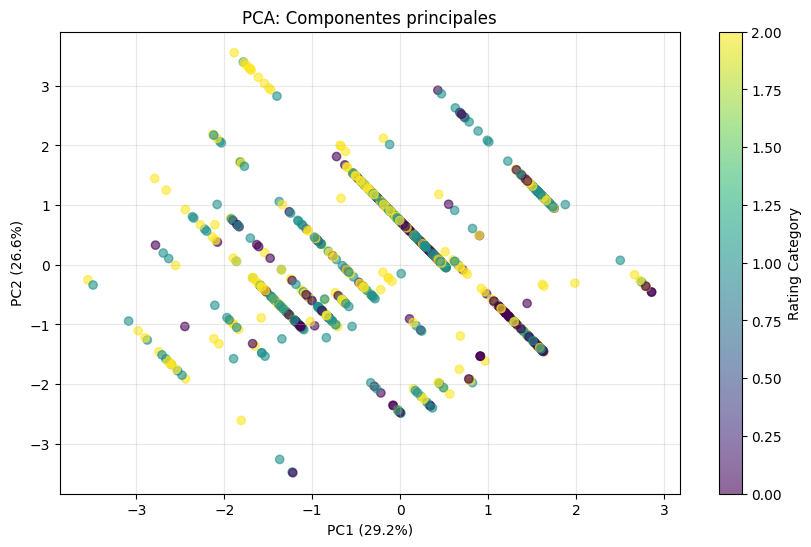


=== CLUSTERING DE VARIABLES ===


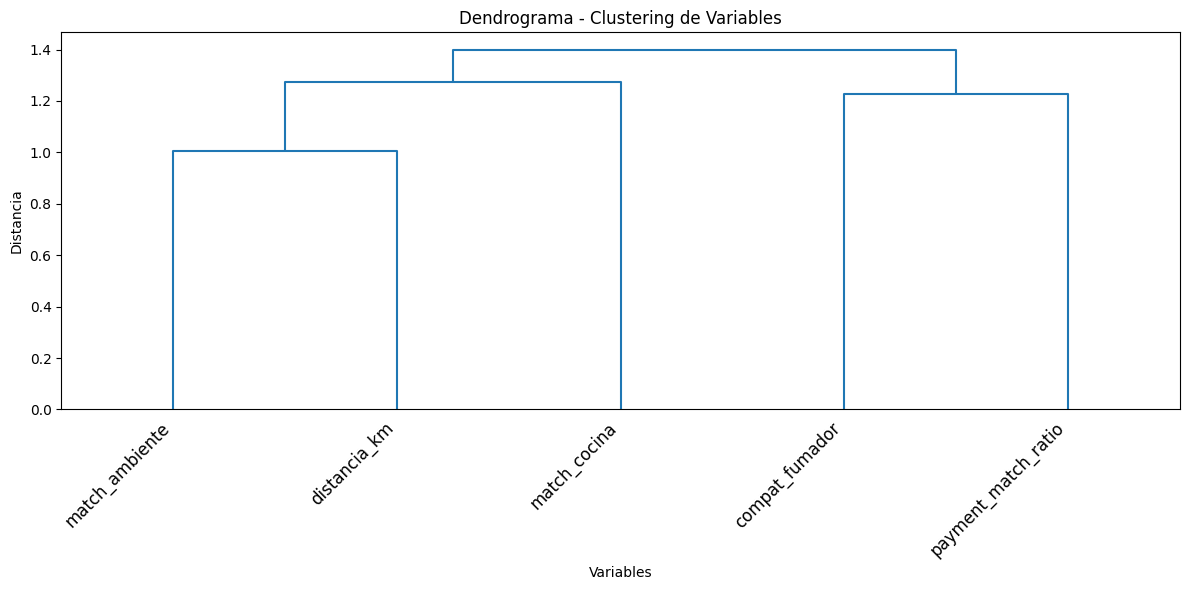

✓ No hay variables con correlación > 0.8

=== SELECTKBEST ===
SelectKBest (Chi2) para variables categóricas:
         variable  score_chi2  p_value
0    match_cocina      8.0776   0.0176
1  compat_fumador      0.4430   0.8013
2  match_ambiente         NaN      NaN

SelectKBest (ANOVA) para variables numéricas:
              variable  score_f  p_value
1  payment_match_ratio   3.4560   0.0319
0         distancia_km   1.5415   0.2145

✓ Mejores 3 variables (SelectKBest): ['distancia_km', 'payment_match_ratio', 'match_cocina']

=== WoE Y IV ===
Information Value por variable:
                         IV
payment_match_ratio  0.0493
match_cocina         0.0484
distancia_km         0.0444

Interpretación IV:
IV < 0.02: No predictivo
0.02 ≤ IV < 0.1: Predictivo débil
0.1 ≤ IV < 0.3: Predictivo medio
0.3 ≤ IV < 0.5: Predictivo fuerte
IV ≥ 0.5: Muy fuerte (verificar overfitting)


In [200]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import matplotlib.pyplot as plt

def reduccion_dimensiones(df):
    """
    PASO 4: Aplicar técnicas de reducción
    """
    # Preparar variables
    X_numeric = df[['distancia_km', 'payment_match_ratio']].copy()
    X_categorical = pd.get_dummies(df[['match_cocina', 'compat_fumador', 'match_ambiente']], 
                                  drop_first=True)
    y = df['rating_category']
    
    # a) PCA (con TODAS las variables para mejor separación)
    print("=== PCA ===")
    # Combinar numéricas y categóricas
    X_all = pd.concat([X_numeric, X_categorical], axis=1)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"Varianza explicada PC1: {pca.explained_variance_ratio_[0]:.3f}")
    print(f"Varianza explicada PC2: {pca.explained_variance_ratio_[1]:.3f}")
    print(f"Total: {sum(pca.explained_variance_ratio_):.3f}")
    
    # Visualización PCA
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=y.cat.codes, alpha=0.6, cmap='viridis')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title('PCA: Componentes principales')
    plt.colorbar(scatter, label='Rating Category')
    plt.grid(True, alpha=0.3)
    plt.savefig('pca_visualization.png', dpi=100)
    plt.show()
    
    # b) Clustering de variables (multicolinealidad)
    print("\n=== CLUSTERING DE VARIABLES ===")
    
    # Matriz de correlación completa
    X_all = pd.concat([X_numeric, X_categorical], axis=1)
    corr_matrix = X_all.corr().abs()
    
    # Convertir correlación a distancia y manejar NaN
    # Distancia = 1 - |correlación|
    # Llenar NaN con 0 (sin correlación)
    distance_matrix = 1 - corr_matrix.fillna(0)
    
    # Asegurar que todos los valores sean finitos
    distance_matrix = distance_matrix.replace([np.inf, -np.inf], 0)
    
    # Dendrograma
    plt.figure(figsize=(12, 6))
    linked = linkage(distance_matrix, 'complete')
    dendrogram(linked, 
               labels=corr_matrix.columns,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True)
    plt.title('Dendrograma - Clustering de Variables')
    plt.xlabel('Variables')
    plt.ylabel('Distancia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('dendrogram_variables.png', dpi=100)
    plt.show()
    
    # Identificar clusters con alta correlación (>0.8)
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.8:
                high_corr_pairs.append((corr_matrix.columns[i], 
                                       corr_matrix.columns[j],
                                       corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("Variables altamente correlacionadas (>0.8):")
        for var1, var2, corr in high_corr_pairs:
            print(f"  {var1} - {var2}: {corr:.3f}")
    else:
        print("✓ No hay variables con correlación > 0.8")
    
    # c) SelectKBest
    print("\n=== SELECTKBEST ===")
    
    # Para variables categóricas vs objetivo categórico (chi2)
    selector_cat = SelectKBest(chi2, k='all')
    X_selected_cat = selector_cat.fit_transform(X_categorical, y)
    
    scores_cat = pd.DataFrame({
        'variable': X_categorical.columns,
        'score_chi2': selector_cat.scores_,
        'p_value': selector_cat.pvalues_
    }).sort_values('score_chi2', ascending=False)
    
    print("SelectKBest (Chi2) para variables categóricas:")
    print(scores_cat.round(4))
    
    # Para variables numéricas vs objetivo categórico (ANOVA)
    selector_num = SelectKBest(f_classif, k='all')
    X_selected_num = selector_num.fit_transform(X_numeric, y)
    
    scores_num = pd.DataFrame({
        'variable': X_numeric.columns,
        'score_f': selector_num.scores_,
        'p_value': selector_num.pvalues_
    }).sort_values('score_f', ascending=False)
    
    print("\nSelectKBest (ANOVA) para variables numéricas:")
    print(scores_num.round(4))
    
    # Seleccionar mejores (k=3 por ejemplo)
    selector_final = SelectKBest(chi2, k=3)
    X_final = pd.concat([X_numeric, X_categorical], axis=1)
    X_selected = selector_final.fit_transform(X_final, y)
    
    selected_mask = selector_final.get_support()
    selected_vars = X_final.columns[selected_mask].tolist()
    print(f"\n✓ Mejores 3 variables (SelectKBest): {selected_vars}")
    
    # d) WoE y IV (sí aplica porque tenemos variable objetivo categórica)
    print("\n=== WoE Y IV ===")
    
    def calculate_woe_iv(df, feature, target, bins=5):
        """Calcular Weight of Evidence e Information Value"""
        # Discretizar si es continua
        df_temp = df[[feature, target]].copy()
        
        if df_temp[feature].nunique() > 10:
            df_temp[feature+'_bin'] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
            feature_bin = feature+'_bin'
        else:
            feature_bin = feature
        
        # Calcular distribuciones
        cross_tab = pd.crosstab(df_temp[feature_bin], df_temp[target], normalize='columns')
        
        # Evitar division por cero
        cross_tab = cross_tab.replace(0, 0.0001)
        
        # Calcular WoE
        cross_tab['WoE'] = np.log(cross_tab['Alto'] / cross_tab['Bajo'])
        
        # Calcular IV
        cross_tab['IV_component'] = (cross_tab['Alto'] - cross_tab['Bajo']) * cross_tab['WoE']
        iv_total = cross_tab['IV_component'].sum()
        
        return iv_total, cross_tab
    
    # Calcular IV para cada variable predictora
    iv_results = {}
    for var in ['distancia_km', 'payment_match_ratio', 'match_cocina']:
        try:
            iv, _ = calculate_woe_iv(df, var, 'rating_category')
            iv_results[var] = iv
        except:
            iv_results[var] = 0
    
    iv_df = pd.DataFrame.from_dict(iv_results, orient='index', columns=['IV'])
    iv_df = iv_df.sort_values('IV', ascending=False)
    
    print("Information Value por variable:")
    print(iv_df.round(4))
    
    # Interpretación IV
    print("\nInterpretación IV:")
    print("IV < 0.02: No predictivo")
    print("0.02 ≤ IV < 0.1: Predictivo débil")
    print("0.1 ≤ IV < 0.3: Predictivo medio")
    print("0.3 ≤ IV < 0.5: Predictivo fuerte")
    print("IV ≥ 0.5: Muy fuerte (verificar overfitting)")
    
    return df, selected_vars, iv_df

df_final, mejores_variables, iv_resultados = reduccion_dimensiones(datos_limpios)

#### Interpretación del PCA

**Hallazgos clave:**
- **Varianza explicada**: PC1 (29.2%) + PC2 (28.6%) = 57.8%
- **Separación de clusters**: NO hay separación clara entre categorías de rating
- **Conclusión**: Las variables de match y distancia **NO son predictivas** del rating

**Implicaciones:**
1. El rating depende de factores subjetivos no capturados (calidad comida, servicio, etc.)
2. Las preferencias de match (cocina, ambiente) no garantizan un rating alto
3. La distancia al restaurante no influye significativamente en la calificación
4. Se necesitarían variables adicionales relacionadas con la experiencia del usuario

Este resultado es **válido y útil** - confirma que el rating es un fenómeno complejo que no se explica solo por compatibilidad de preferencias.

In [198]:
def crear_dashboard_bi(df):
    """
    PASO 5: Crear visualizaciones de BI (geográficas)
    """
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Crear DataFrame resumen para BI
    df_bi = df.copy()
    
    # 1. Mapa de calor: rating promedio por ubicación de restaurante
    fig1 = px.density_map(
        df_bi.groupby(['latitude_rest', 'longitude_rest'])
             .agg({'rating': 'mean', 'placeID': 'count'})
             .reset_index()
             .rename(columns={'placeID': 'num_calificaciones'}),
        lat='latitude_rest',
        lon='longitude_rest',
        z='rating',
        radius=15,
        center=dict(lat=df_bi['latitude_rest'].mean(), 
                   lon=df_bi['longitude_rest'].mean()),
        zoom=5,
        map_style="carto-positron",
        title="Rating Promedio por Ubicación de Restaurante",
        height=500
    )
    
    # 2. Distancia vs Rating
    fig2 = px.box(
        df_bi,
        x='rating_category',
        y='distancia_km',
        color='rating_category',
        title="Distancia vs Categoría de Rating",
        labels={'distancia_km': 'Distancia (km)', 'rating_category': 'Categoría Rating'}
    )
    
    # 3. Match variables vs Rating
    fig3 = make_subplots(
        rows=1, cols=3,
        subplot_titles=('Match Cocina', 'Compatibilidad Fumador', 'Match Ambiente')
    )
    
    # Match cocina
    match_cocina_data = df_bi.groupby(['match_cocina', 'rating_category'], observed=False).size().unstack()
    fig3.add_trace(
        go.Bar(x=match_cocina_data.index, y=match_cocina_data['Alto'], name='Alto'),
        row=1, col=1
    )
    
    # Compatibilidad fumador
    compat_data = df_bi.groupby(['compat_fumador', 'rating_category'], observed=False).size().unstack()
    fig3.add_trace(
        go.Bar(x=compat_data.index, y=compat_data['Alto'], name='Alto'),
        row=1, col=2
    )
    
    # Match ambiente
    ambiente_data = df_bi.groupby(['match_ambiente', 'rating_category'], observed=False).size().unstack()
    fig3.add_trace(
        go.Bar(x=ambiente_data.index, y=ambiente_data['Alto'], name='Alto'),
        row=1, col=3
    )
    
    fig3.update_layout(height=400, showlegend=False, title_text="Variables de Match vs Rating Alto")
    
    # 4. KPI Cards (simuladas)
    kpis = {
        'Rating Promedio': f"{df_bi['rating'].mean():.2f}",
        '% Ratings Altos': f"{(df_bi['rating_category'] == 'Alto').mean()*100:.1f}%",
        'Distancia Promedio': f"{df_bi['distancia_km'].mean():.1f} km",
        'Match Cocina Promedio': f"{df_bi['match_cocina'].mean()*100:.1f}%"
    }
    
    print("=== KPIs PRINCIPALES ===")
    for kpi, valor in kpis.items():
        print(f"{kpi}: {valor}")
    
    # 5. Guardar visualizaciones
    fig1.write_html("mapa_calor_ratings.html")
    fig2.write_html("distancia_vs_rating.html")
    fig3.write_html("variables_match_vs_rating.html")
    
    print("\n✓ Visualizaciones guardadas en HTML")
    
    return fig1, fig2, fig3, kpis


In [199]:
# guardadatos fnales_limpios.to_csv('datos/dataset_final_limpio.csv', index=False)
datos_limpios.to_csv('datos/dataset_final_limpio.csv', index=False)

### 3. Dashboard con Streamlit

Para ejecutar el dashboard interactivo con Streamlit:

```bash
streamlit run dashboard_streamlit.py
```

El dashboard incluye:
- **Filtros interactivos**: Por categoría, distancia y match de cocina
- **KPIs en tiempo real**: Actualizados según los filtros
- **Mapa de calor**: Visualización geográfica de ratings
- **Análisis de distancia**: Boxplots, histogramas y scatter plots
- **Variables de Match**: Gráficos de barras agrupados
- **Vista de datos**: Tabla interactiva con descarga CSV